Chapter 7 Exercises

In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm


from pygam import (s as s_gam, l as l_gam,  f as f_gam, LinearGAM, LogisticGAM)

from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

print('Done')

Done


9

A

In [2]:
Boston = load_data("Boston")
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [3]:
y = Boston['nox']

x = Boston['dis']

In [4]:
poly_dis = MS([poly('dis', degree=3)]).fit(Boston)
M = sm.OLS(y, poly_dis.transform(Boston)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.5547,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.0031,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.8563,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.3180,0.062,-5.124,0.0


In [5]:
dis_grid = np.linspace(x.min(), x.max(), 100)
dis_df = pd.DataFrame({'dis': dis_grid})

In [6]:
def plot_wage_fit(dis_df, basis, title):

    X = basis.transform(Boston)
    Xnew = basis.transform(dis_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(x, y, facecolor='gray', alpha=0.5)
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Dis', fontsize=20)
    ax.set_ylabel('Nox', fontsize=20);
    return ax

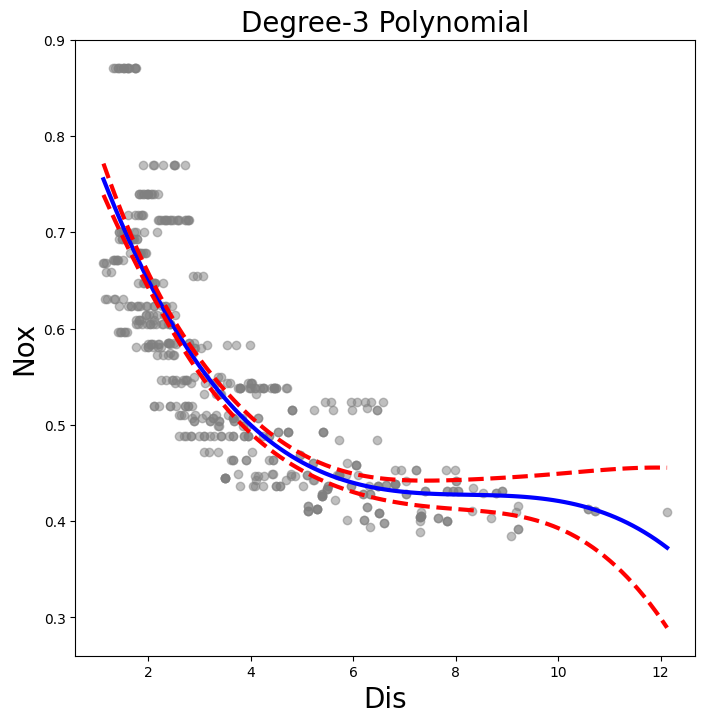

In [7]:
plot_wage_fit(dis_df, poly_dis, 'Degree-3 Polynomial');

B

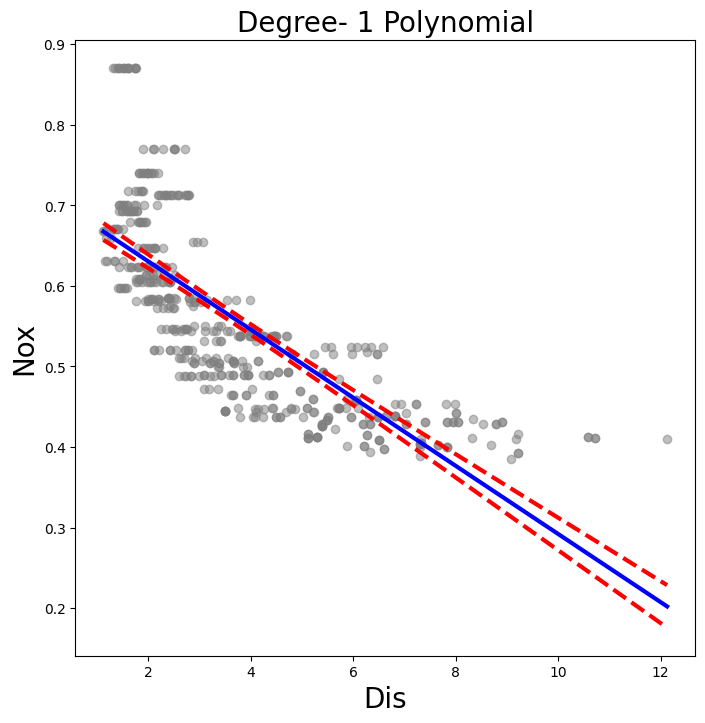

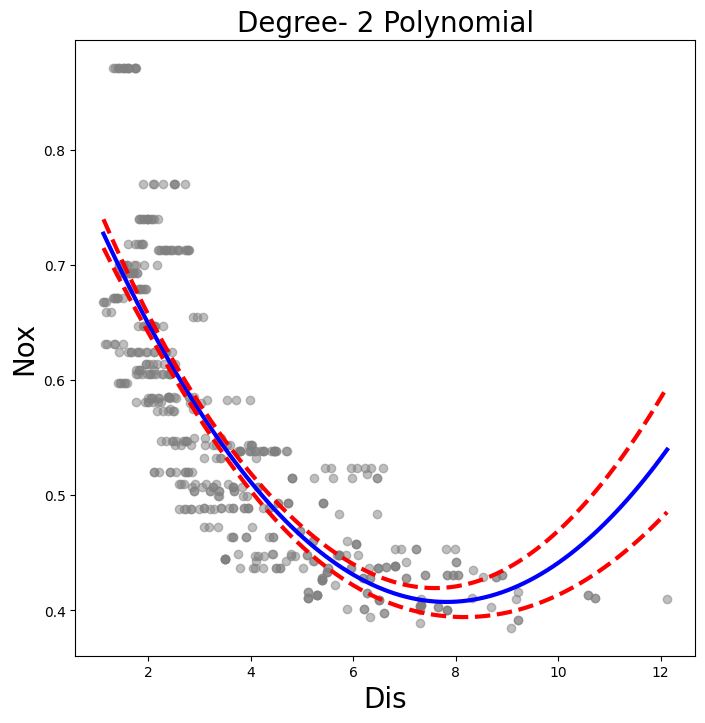

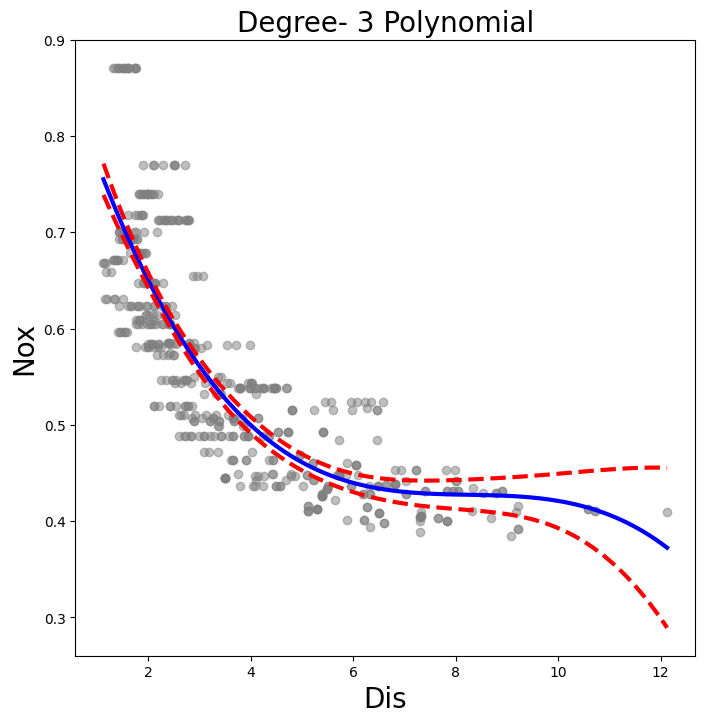

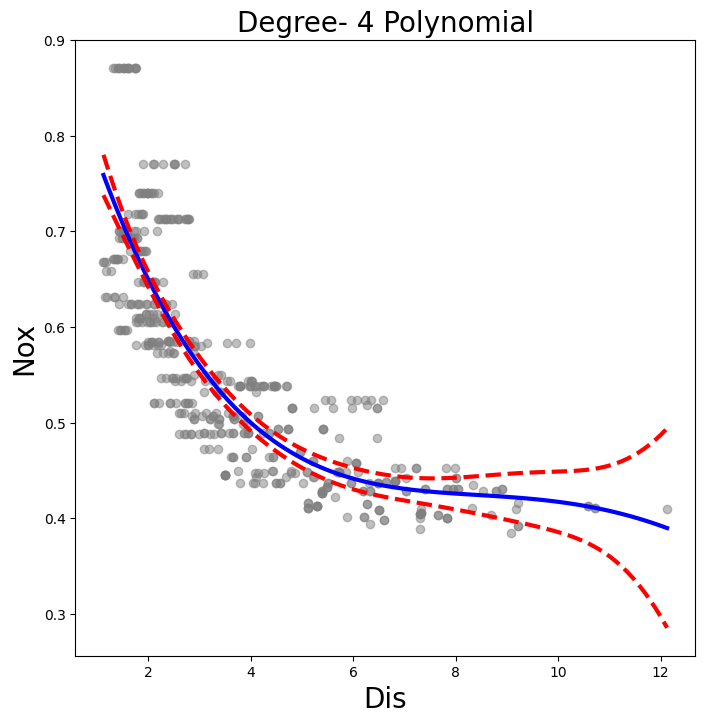

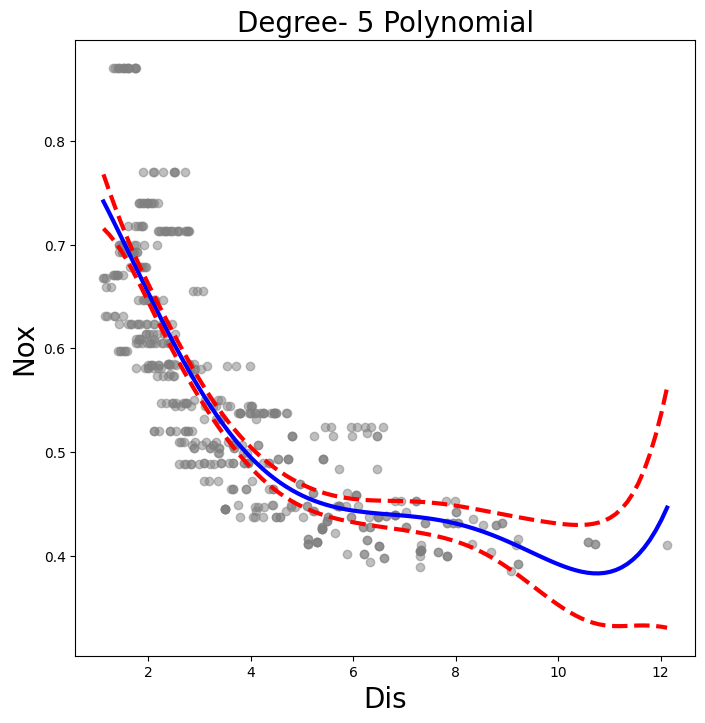

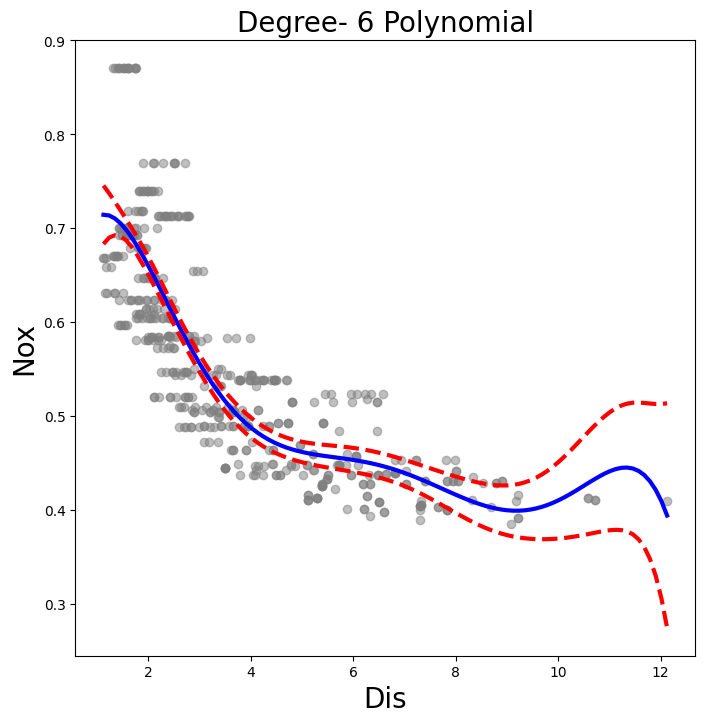

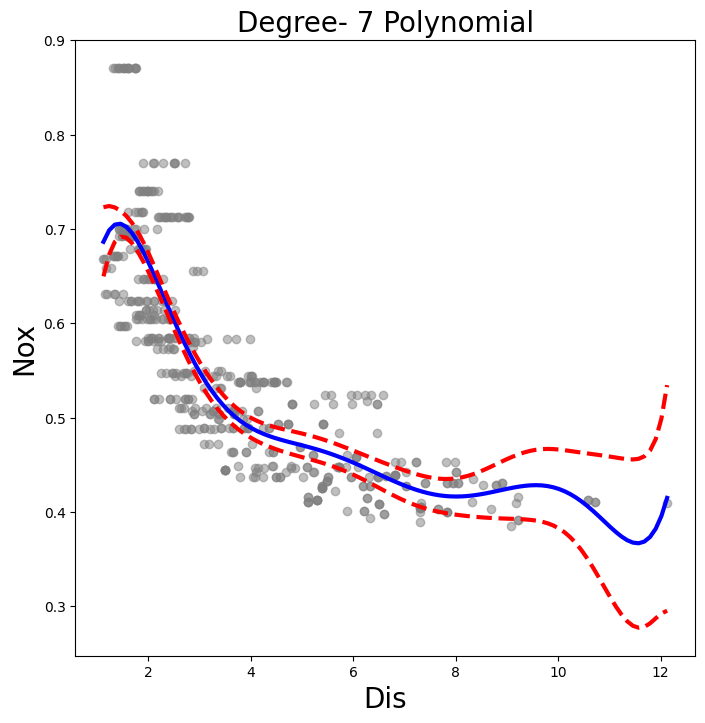

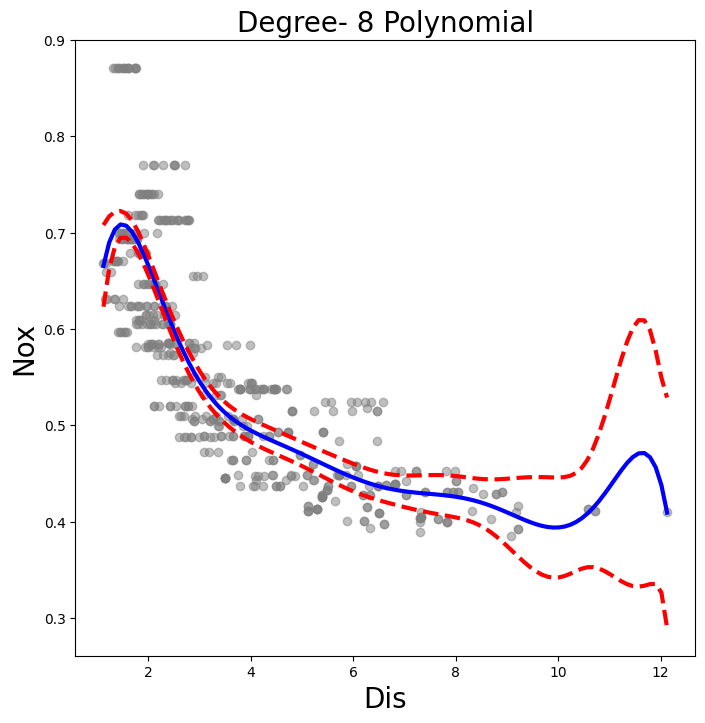

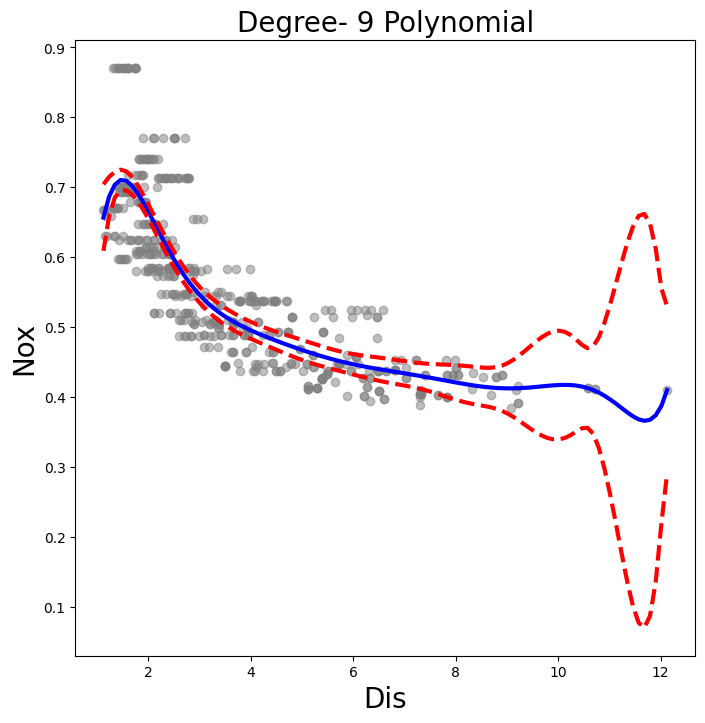

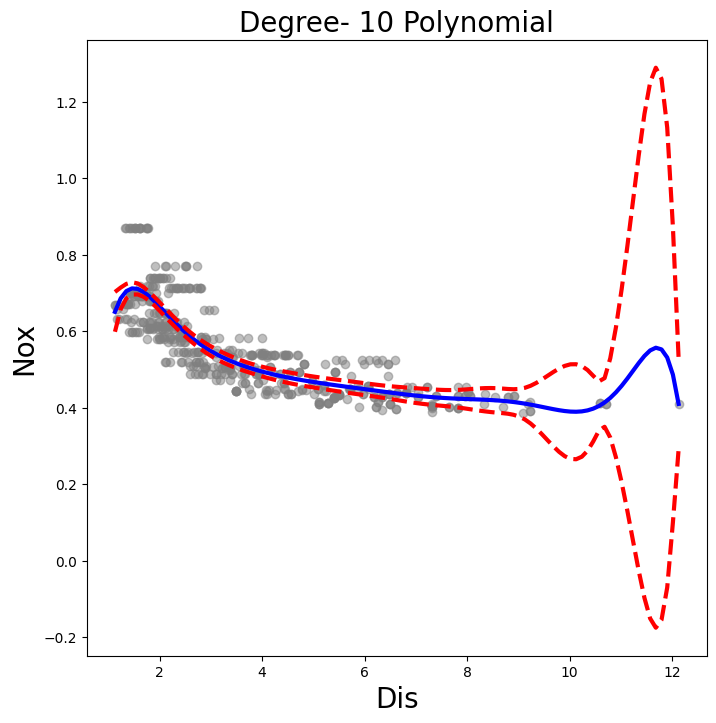

In [8]:
for i in range(1,11):
    poly_dis = MS([poly('dis', degree=i)]).fit(Boston)
    M = sm.OLS(y, poly_dis.transform(Boston)).fit()
    plot_wage_fit(dis_df, poly_dis, f"Degree- {i} Polynomial");
    

C

In [9]:
models = [MS([poly('dis', degree=d)]) for d in range(1,11)]
Xs = [model.fit_transform(Boston) for model in models]
anova_lm(*[sm.OLS(y,X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,2.768563,0.0,NaN,NaN,NaN
1,503.0,2.035262,1.0,0.733301,198.116860,3.558589e-38
2,502.0,1.934107,1.0,0.101155,27.329219,2.522104e-07
3,501.0,1.932981,1.0,0.001125,0.304045,5.816033e-01
4,500.0,1.915290,1.0,0.017691,4.779699,2.926006e-02
5,499.0,1.878257,1.0,0.037033,10.005161,1.656138e-03
6,498.0,1.849484,1.0,0.028774,7.773823,5.503632e-03
7,497.0,1.835630,1.0,0.013854,3.742933,5.359844e-02
8,496.0,1.833331,1.0,0.002299,0.621093,4.310180e-01
9,495.0,1.832171,1.0,0.001160,0.313312,5.759079e-01


This Suggests a Cubic fit is preferable.

D

In [10]:
ns_dis = MS([ns('dis', df=4)]).fit(Boston)
M_ns = sm.OLS(y, ns_dis.transform(Boston)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,0.7303,0.013,57.229,0.0
"ns(dis, df=4)[0]",-0.2431,0.014,-17.703,0.0
"ns(dis, df=4)[1]",-0.2700,0.017,-15.666,0.0
"ns(dis, df=4)[2]",-0.3880,0.032,-12.206,0.0
"ns(dis, df=4)[3]",-0.3046,0.031,-9.810,0.0


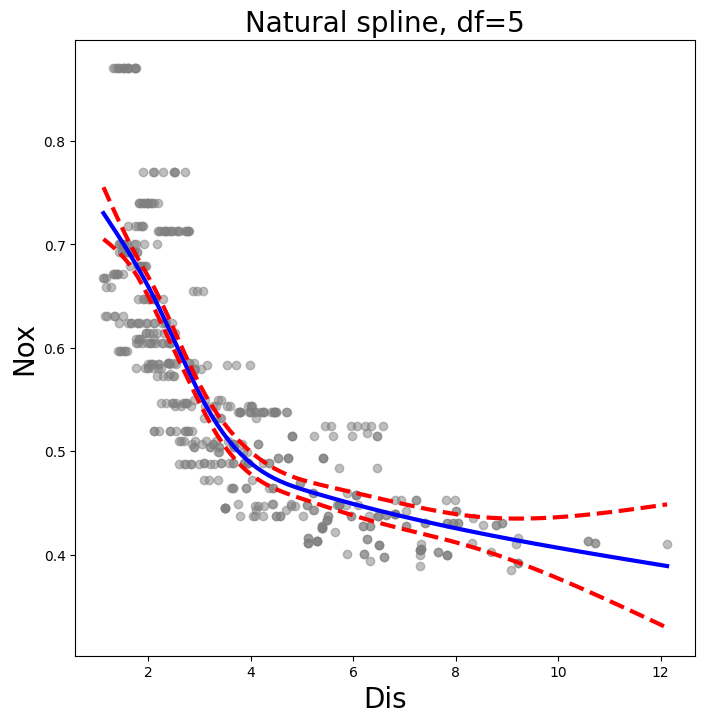

In [11]:
plot_wage_fit(dis_df, ns_dis, 'Natural spline, df=5');

10

A

In [12]:
College = load_data("College")
College

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


In [21]:
College = College[College.columns.drop("Private")]
College

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


In [22]:
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

from sklearn.model_selection import train_test_split

In [23]:
College_train, College_test = train_test_split(College, test_size= 200, random_state= 0)

In [24]:
MM = MS(College.columns.drop("Outstate"))
design = MM.fit(College)
X_train = MM.fit_transform(College)
Y_train = College_train['Outstate']

In [40]:
strategy = Stepwise.first_peak(design, direction='forward', max_terms= len(design.terms)-6)
College_MSE = sklearn_selected(sm.OLS, strategy, scoring= 'r2')
College_MSE.fit(College_train, Y_train)
College_MSE.selected_state_

('Accept',
 'Apps',
 'Expend',
 'F.Undergrad',
 'Grad.Rate',
 'Room.Board',
 'S.F.Ratio',
 'Terminal',
 'Top10perc',
 'perc.alumni')